In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore 
from qdrant_client import QdrantClient
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langchain_ollama import OllamaEmbeddings
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition

In [3]:
load_dotenv()
import os
OPENAI_URL=os.getenv("OPENAI_URL")

In [4]:
llm=ChatOpenAI(model='qwen3-40k',base_url=OPENAI_URL, api_key="NA")

In [5]:
llm.invoke("hi")

AIMessage(content='<think>\nOkay, the user said "hi". I need to respond in a friendly and helpful way. Since the conversation is in English, I should keep the response in English too. Maybe start with a greeting like "Hello!" and then offer assistance. Let me make sure it\'s welcoming and open-ended so they feel comfortable to ask questions. Also, I should keep it concise but friendly. Let me check if there are any other elements I should include, but I think that\'s enough for now.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 115, 'prompt_tokens': 9, 'total_tokens': 124, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'qwen3-40k', 'system_fingerprint': 'fp_ollama', 'id': 'chatcmpl-802', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c27e2-3e45-7c93-bb72-a286456caf4c-0', tool_calls=[], invalid_tool_calls=[], usage_m

In [7]:
loader = PyPDFLoader("intro-to-ml.pdf")
docs = loader.load()

In [8]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

In [9]:
len(chunks)

973

In [10]:
embedding_model = OllamaEmbeddings(
        model="all-minilm:l6-v2", 
        base_url=os.getenv("BASE_URL")
    )

In [13]:
#vector_store = FAISS.from_documents(chunks, embedding_model)
url = os.getenv("QDRANT_URL") 
api_key = os.getenv("QDRANT_API_KEY") # Use None if running locally without an API key

vector_store = QdrantVectorStore.from_documents(
    documents=chunks,
    embedding=embedding_model,
    url=url,
    api_key=api_key,
    collection_name="chatbot_embeddings",
    force_recreate=False  # Set to False once the collection is created to avoid re-uploading
)

In [14]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

In [15]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }


In [16]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]



In [17]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}

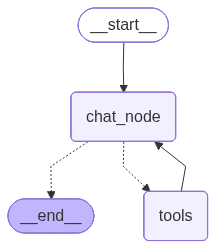

In [18]:
tool_node = ToolNode(tools)

graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

chatbot

In [19]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

print(result['messages'][-1].content)



<think>
Okay, let's tackle the user's question about finding the ideal K value in KNN using the provided pdf notes. First, I need to recall what I know about KNN and hyperparameter tuning. KNN is a simple algorithm where the number of neighbors (K) affects the model's performance. Choosing the right K is crucial because a small K can make the model sensitive to noise, while a large K might smooth out decision boundaries too much.

The user mentioned using the pdf notes, so I should focus on the information from the provided context. Looking at the tool response, there are several snippets. The first few entries mention the KNeighborsClassifier from scikit-learn, showing parameters like n_neighbors=1, which is the default. However, the user wants to find the ideal K, not just the default.

The next part of the context shows code where they fit the model and compute the test set score. The accuracy is 0.97, which is high, but that's with K=1. The user probably wants to know how to determ